<a href="https://colab.research.google.com/github/banrovegrie/Nostradamus/blob/main/src/Nostradamus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import snowflake.connector
except:
    !pip install snowflake-connector-python
    import snowflake.connector

from pprint import pprint
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
import requests

try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

     |████████████████████████████████| 14.9 MB 138 kB/s 
     |████████████████████████████████| 3.0 MB 43.3 MB/s 
     |████████████████████████████████| 131 kB 63.6 MB/s 
     |████████████████████████████████| 104 kB 67.0 MB/s 
     |████████████████████████████████| 192 kB 61.8 MB/s 
     |████████████████████████████████| 1.9 MB 49.2 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 356 kB 48.3 MB/s 
     |████████████████████████████████| 176 kB 60.2 MB/s 
     |████████████████████████████████| 85 kB 4.0 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 8.0 MB 47.3 MB/s 
     |████████████████████████████████| 138 kB 46.9 MB/s 
     |████████████████████████████████| 45 kB 2.9 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninst

In [74]:
#create connection
conn=snowflake.connector.connect(
    user='ZSHAN0',
    password='Zee@snowflack0',
    account='pg84506.ap-south-1.aws',
    database='US_STOCKS_DAILY',
)

In [3]:
def showTables(curs):
  curs.execute("SHOW TABLES")

  tables = [x[1] for x in curs.fetchall()]
  return tables

In [4]:
curs=conn.cursor()
curs.execute("SHOW TABLES")
tables = showTables(curs)
tables

['COMPANY_PROFILE', 'STOCK_HISTORY', 'SYMBOLS']

In [5]:
columnNames = {
    'COMPANY_PROFILE': [], 
    'STOCK_HISTORY': [], 
    'SYMBOLS': [], 
}

In [6]:
curs.execute("DESCRIBE SYMBOLS")
res = curs.fetchall()
[x[0] for x in res]

['ID', 'SYMBOL', 'NAME', 'EXCHANGE']

# Getting data

In [7]:
def getColumns(curs, tableName):
    curs.execute(f"DESCRIBE {tableName}")
    return [x[0] for x in curs.fetchall()]

In [8]:
for table in tables:
    print(getColumns(curs, table))

['ID', 'SYMBOL', 'PRICE', 'BETA', 'VOLAVG', 'MKTCAP', 'LASTDIV', 'RANGE', 'CHANGES', 'COMPANYNAME', 'EXCHANGE', 'INDUSTRY', 'WEBSITE', 'DESCRIPTION', 'CEO', 'SECTOR', 'DCFDIFF', 'DCF']
['ID', 'SYMBOL', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'ADJCLOSE']
['ID', 'SYMBOL', 'NAME', 'EXCHANGE']


In [9]:
def getData(curs, tableName, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM {tableName}")
    else:
        curs.execute(f"SELECT * FROM {tableName} LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, tableName)
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [10]:
symbols = getData(curs, 'SYMBOLS')

In [11]:
def getDataFromSymbols(curs, symbol, numRows=0):
    if numRows == 0:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}'")
    else:
        curs.execute(f"SELECT * FROM STOCK_HISTORY WHERE SYMBOL='{symbol}' LIMIT {numRows}")
    rows = curs.fetchall()
    columnNames = getColumns(curs, "STOCK_HISTORY")
    df = pd.DataFrame(rows, columns=columnNames)
    return df

In [12]:
aapl = getDataFromSymbols(curs, 'AAPL')
len(aapl)

10278

In [13]:
aapl.sort_values(by=["DATE"], inplace = True)


In [75]:
# aapl.to_csv(r'aapl.csv', index = False, header = True)
# files.download('aapl.csv') 

In [15]:
def saveData(curs, symbolList):
    for company in symbolList:
        df = getDataFromSymbols(curs, company)
        df.sort_values(by=["DATE"], inplace = True)
        df.to_csv(f'{company}.csv', index = False, header = True)
        files.download(f'{company}.csv') 

In [16]:
# saveData(curs, 
#          [
#           "ADM", "BAYRY", "BG", "SMG"
#           "AAPL", "BP", "CVX", 
#           "XOM", "EPD", "COP", "EOG", "NRG", "XEL",  # energy companies
#           "GNRC", "PPSI", "VST" # electronics
#          ]
#          )

# Environment Data

In [17]:
curs.execute("USE ENV")

In [18]:
tables = showTables(curs)
tables

['DATASETS', 'DATA_ATLAS']

In [19]:
datasets = getData(curs, "DATASETS")
data_atlas = getData(curs, "DATA_ATLAS")

In [20]:
data_atlas.head()

,Dataset,Path,Country,Country ISO Code,Topic,Subtopic,Indicator,Description,Source,Uri,Year,Month,Unit,Date,Value
0,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1970,1,Mton CO2,1970-01-01,19.43696
1,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1971,1,Mton CO2,1971-01-01,25.40343
2,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1972,1,Mton CO2,1972-01-01,27.71823
3,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1973,1,Mton CO2,1973-01-01,35.80548
4,EDGARED2019,location=AE;indicator=KN.F1;type=All;Frequency=A,United Arab Emirates,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,EDGAR,https://knoema.com/atlas/United-Arab-Emirates/...,1974,1,Mton CO2,1974-01-01,35.97032


# Cleaning Data

`location=AE;indicator=KN.F1;type=All;Frequency=A`

To split the values into different columns

In [21]:
def splitPath(string, originalAttr):
    string = string.lower()
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        if attr == originalAttr:
            return val
    return None

In [22]:
attributesList = []
def func(string):
    l = string.split(';')
    for x in l:
        attr, val = x.split('=')
        attributesList.append(attr)

data_atlas.apply(lambda x: func(x['Path']), axis=1)
list(set(attributesList))

['location',
 'variable',
 'indicator',
 'Variable',
 'series',
 'country',
 'Frequency',
 'type']

In [23]:

splitPath('location=AE;indicator=KN.F1;type=All;Frequency=A', 2)
data_atlas['location'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'location'), axis=1)
data_atlas['indicator'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'indicator'), axis=1)
data_atlas['type'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'type'), axis=1)
data_atlas['frequency'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'frequency'), axis=1)
data_atlas['series'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'series'), axis=1)
data_atlas['variable'] = data_atlas.apply(lambda x: splitPath(x['Path'], 'variable'), axis=1)
data_atlas.drop(['Path', 'Country', 'Dataset', 'Source', 'Uri', 'Year', 'Month'], axis=1, inplace=True)

In [24]:
data_atlas.head()

,Country ISO Code,Topic,Subtopic,Indicator,Description,Unit,Date,Value,location,indicator,type,frequency,series,variable
0,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1970-01-01,19.43696,ae,kn.f1,all,a,None,None
1,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1971-01-01,25.40343,ae,kn.f1,all,a,None,None
2,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1972-01-01,27.71823,ae,kn.f1,all,a,None,None
3,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1973-01-01,35.80548,ae,kn.f1,all,a,None,None
4,AE,Environment,,CO2 emissions,Carbon dioxide emissions are those stemming fr...,Mton CO2,1974-01-01,35.97032,ae,kn.f1,all,a,None,None


In [25]:
curs.execute('select DISTINCT "Indicator" from DATA_ATLAS')
indicators = list(set([x[0] for x in curs.fetchall()]))

In [26]:
indicators

['Methane emissions',
 'CO2 emissions from gaseous fuel consumption',
 'CO2 emissions intensity',
 'Use of nitrogen',
 'CO2 emissions from gas fuel consumption',
 'Quantity of municipal waste collected',
 'CO2 emissions from gas flaring',
 'Threatened bird species',
 'Threatened mammal species',
 'Threatened fish species',
 'Agricultural nitrous oxide emissions',
 'Consumption of ozone-depleting substances',
 'CO2 emissions: residential buildings (%)',
 'Use of potash',
 'Nitrous oxide emissions',
 'Consumption of hydrochlorofluorocarbons',
 'CO2 emissions from fossil-fuels',
 'PM2.5 air pollution',
 'Other greenhouse gas emissions',
 'CO2 emissions from solid fuel consumption',
 'Agricultural methane emissions',
 'CO2 emissions from electricity production (%)',
 'Terrestrial protected areas',
 'Use of phosphate',
 'Marine protected areas',
 'CO2 emissions',
 'CO2 emissions: transport (%)',
 'CO2 intensity',
 'Agricultural nitrous oxide emissions (%)',
 'Terrestrial and marine protecte

In [27]:
def locateIndicators(x):
    return indicators.index(x)

In [28]:
data_atlas['Indicator'] = data_atlas.apply(lambda x: locateIndicators(x['Indicator']), axis=1)

In [29]:
data_atlas

,Country ISO Code,Topic,Subtopic,Indicator,Description,Unit,Date,Value,location,indicator,type,frequency,series,variable
0,AE,Environment,,25,Carbon dioxide emissions are those stemming fr...,Mton CO2,1970-01-01,19.43696,ae,kn.f1,all,a,None,None
1,AE,Environment,,25,Carbon dioxide emissions are those stemming fr...,Mton CO2,1971-01-01,25.40343,ae,kn.f1,all,a,None,None
2,AE,Environment,,25,Carbon dioxide emissions are those stemming fr...,Mton CO2,1972-01-01,27.71823,ae,kn.f1,all,a,None,None
3,AE,Environment,,25,Carbon dioxide emissions are those stemming fr...,Mton CO2,1973-01-01,35.80548,ae,kn.f1,all,a,None,None
4,AE,Environment,,25,Carbon dioxide emissions are those stemming fr...,Mton CO2,1974-01-01,35.97032,ae,kn.f1,all,a,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339447,ZW,Environment,Stratospheric Ozone Depletion,15,Ozone-depleting substances are any substance c...,ODP Metric Tons,2010-01-01,18.50000,zw,None,None,a,None,consumption of ozone-depleting substances - hy...
339448,ZW,Environment,Stratospheric Ozone Depletion,15,Ozone-depleting substances are any substance c...,ODP Metric Tons,2011-01-01,19.82000,zw,None,None,a,None,consumption of ozone-depleting substances - hy...
339449,ZW,Environment,Stratospheric Ozone Depletion,15,Ozone-depleting substances are any substance c...,ODP Metric Tons,2012-01-01,16.20000,zw,None,None,a,None,consumption of ozone-depleting substances - hy...
339450,ZW,Environment,Stratospheric Ozone Depletion,15,Ozone-depleting substances are any substance c...,ODP Metric Tons,2013-01-01,15.76000,zw,None,None,a,None,consumption of ozone-depleting substances - hy...


In [39]:
def co2_emission(country):
    co2 = data_atlas[(data_atlas['Unit'] == 'Mton CO2') & (data_atlas['Country ISO Code'] == country)]
    co2['Year'] = co2.apply(lambda x: x["Date"].year, axis=1)
    return co2[['Year', 'Value']]

In [40]:
co2_emission('US')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Year,Value
8450,1970,4685.42942
8451,1971,4550.80871
8452,1972,4799.58289
8453,1973,4987.24848
8454,1974,4822.62093
8455,1975,4608.94786
8456,1976,4903.63553
8457,1977,5067.79410
8458,1978,5062.23640
8459,1979,5100.60996


# Getting data about the companies sustainibility

In [41]:
def yearlyData(companyName):
    df = yf.download(tickers=companyName, period='max', interval='3mo', threads=True)
    df = df[df['Open'].notna()]
    df['Year'] = df.apply(lambda x: x.name.year, axis=1)
    df = df.groupby(['Year']).mean()
    df['Year'] = df.index
    df.reset_index(drop=True, inplace=True)
    return df

In [42]:
yearly = yearlyData('XOM')
yearly

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Open,High,Low,Close,Adj Close,Volume,Year
0,6.261719,6.722656,5.960938,6.597656,1.801311,4.081966e+08,1985
1,7.464844,8.253906,7.046875,7.937500,2.316753,4.819400e+08,1986
2,10.863281,12.000000,9.574219,11.015625,3.377951,5.023350e+08,1987
3,10.640625,11.687500,10.140625,11.007812,3.535906,3.490572e+08,1988
4,11.007812,11.921875,10.671875,11.414062,3.854104,3.362509e+08,1989
5,12.031250,12.960938,11.523438,12.179688,4.328052,2.948728e+08,1990
6,14.265625,15.203125,13.625000,14.812500,5.531475,2.715568e+08,1991
7,15.046875,15.945312,14.195312,15.101562,5.905618,2.572423e+08,1992
8,16.187500,16.804688,15.335938,16.304688,6.675153,2.738262e+08,1993
9,14.976562,15.945312,14.398438,14.867188,6.366874,3.033785e+08,1994


In [43]:
def mergeOnYear(attribute, country, company):
    yearly = yearlyData(company)
    x = yearly[[attribute, 'Year']]
    y = co2_emission(country)
    xy = pd.merge(x, y, on='Year', how='inner') 
    return xy

In [57]:
def correlation(x, country, company):
    df_cov = mergeOnYear(x, country, company)
    print(df_cov.head())
    print()
    print("Correlation = ", df_cov[x].corr(df_cov['Value']))
    print()
    plt.plot(df_cov['Year'], (df_cov[x] - df_cov[x].min())/(df_cov[x].max() - df_cov[x].min()))
    plt.plot(df_cov['Year'], (df_cov['Value'] - df_cov['Value'].min())/(df_cov['Value'].max() - df_cov['Value'].min()))

[*********************100%***********************]  1 of 1 completed
        Open  Year       Value
0  11.382812  1985  4775.39958
1  11.656250  1986  4734.69220
2  16.757812  1987  4892.10505
3  13.593750  1988  5115.29985
4  14.382812  1989  5172.66620

Correlation =  0.8158776413348325



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


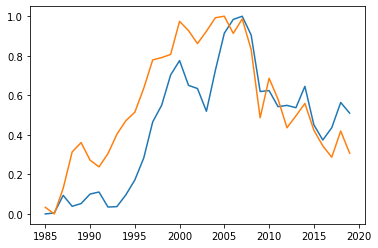

In [73]:
correlation('Open', 'US', 'BP')